# Ring Star Problem

Given an undirected complete graph $G = (V \cup W, E)$, where:
- $V$ is the set of **cycle nodes**, also called **cycle nodes**;
- $W$ is the set of **terminal nodes**,
  which must be assigned to nodes in $V$;
- $E$ is the set of **edges** (both between cycle nodes and between a cycle node and a terminal node).

### Constraints

1. **Hamiltonian Cycle**: The subgraph induced on the nodes $V$ must form a cycle.
2. **Assignment**: Each terminal node $w \in W$ must be assigned to exactly one node $v \in V$.
3. **Connectivity**: The cycle on the nodes $V$ must be connected, and the edges connecting terminal nodes cannot form independent cycles.

### Objective Function

The objective function to minimize is the sum of the costs of the cycle on nodes $V$ and the assignment costs of nodes $W$ to nodes $V$.

$$
\text{min:} \quad \sum_{(i,j) \in E_{cycle}} c_{ij} x_{ij} + \sum_{(v,w) \in E_{assign}} c_{vw} y_{vw}
$$

Where:
- $c_{ij}$ is the cost associated with the edge $(i,j)$ in the cycle between nodes $V$;
- $c_{vw}$ is the cost associated with assigning terminal node $w$ to node $v$;
- $x_{ij} \in \{0,1\}$ is a binary variable indicating whether edge $(i,j)$ is included in the cycle;
- $y_{vw} \in \{0,1\}$ is a binary variable indicating whether terminal node $w$ is assigned to node $v$.

### Model Constraints

**Cycle Constraints**: Each cycle node must have exactly two incident edges to form a Hamiltonian cycle.

$$
\sum_{j \in V : (i,j) \in E_{cycle}} x_{ij} = 2 \quad \forall i \in V
$$

**Assignment Constraints**: Each terminal node must be assigned to exactly one cycle node.

$$
\sum_{v \in V} y_{vw} = 1 \quad \forall w \in W
$$

**Connectivity Constraints**: Constraints must be imposed to avoid subtours within the cycle. If a cycle smaller than $|V|$ is found, it must be eliminated by adding the following constraint:

$$
\sum_{(i,j) \in C} x_{ij} \leq |C| - 1 \quad \text{for every subtour } C
$$

In [9]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import random

class RingStarProblem:
    def __init__(self, max_v=None, max_w=None, input_graph=None):
        if input_graph:
            self.G = input_graph
            self.V = max_v  # nodi del ciclo come max_v
            self.W = max_w  # nodi terminali come max_w
        else:
            self.max_v = max_v
            self.max_w = max_w
            self.total_nodes = max_v + max_w
            self.V = list(range(1, max_v + 1))
            self.W = list(range(max_v + 1, self.total_nodes + 1))
            self.G = nx.complete_graph(self.W + self.V)
            
            self.cycle_edges = [(i, j) for i in self.V for j in self.V if i < j]
            self.assignment_edges = [(v, w) for v in self.V for w in self.W] + [(v, v) for v in self.V]
    
            # archi del ciclo
            self.ring_cost = {}
            for edge in self.cycle_edges:
                cost = random.randint(1, 40)
                self.G.edges[edge]['cost'] = cost
                self.ring_cost[edge] = cost
            
            # archi assegnazione
            self.assignment_cost = {}
            for edge in self.assignment_edges:
                if self.G.has_edge(edge[0], edge[1]):
                    cost = random.randint(1, 40)
                    self.G.edges[edge]['cost'] = cost
                    self.assignment_cost[edge] = cost
                else:
                    print(f"Warning: edge {edge} not found in the graph.")
                
            
    
        print("========== INITIAL INFO ==========")
        print("Cycle nodes (" + str(len(self.V)) + ") :", self.V)
        print("Terminal nodes(" + str(len(self.W)) + ") :", self.W)
        print("==================================")
    
        # costi dal grafo di input per gli archi del ciclo e dell'assegnazione selezionati
        cycle_edges = [(i, j) for i in self.V for j in self.V if i < j]
        assignment_edges = [(v, w) for v in self.V for w in self.W]
    
        # inserisco i costi del ciclo e assegnazione
        ring_cost = {edge: self.G.edges[edge]['cost'] for edge in cycle_edges}
        assignment_cost = {(v, w): self.G.edges[v, w]['cost'] for v, w in assignment_edges}
    
        self.cycle_edges = cycle_edges
        self.assignment_edges = assignment_edges
        self.ring_cost = ring_cost
        self.assignment_cost = assignment_cost

    def create_graph(self):
        if not hasattr(self, 'G') or self.G is None:
            self.G = nx.Graph()
            self.G.add_nodes_from(self.V + self.W)
            self.G.add_edges_from(self.cycle_edges + [(v, w) for v, w in self.assignment_edges if v != w])
            
    def draw_initial_graph_minimum(self):
        pos = nx.spring_layout(self.G, k=0.15, iterations=50)
        plt.figure(figsize=(20, 12))
    
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.V, node_color='lightblue', node_size=500)
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.W, node_color='lightgreen', node_size=300)
    
        # archi di costo minimo
        min_cost = min(self.assignment_cost.values())
        min_cost_edges = [edge for edge, cost in self.assignment_cost.items() if cost == min_cost]
    
        # archi ciclo in rosso
        nx.draw_networkx_edges(self.G, pos, edgelist=self.cycle_edges, edge_color='black', style='solid', width=2)
    
        # archi assegnazione in blu
        non_min_edges = [(v, w) for v, w in self.assignment_edges if (v, w) not in min_cost_edges]
        nx.draw_networkx_edges(self.G, pos, edgelist=non_min_edges, edge_color='blue', style='dashed')
    
        # assegnazione costo minimo in verde 
        #nx.draw_networkx_edges(self.G, pos, edgelist=min_cost_edges, edge_color='green', style='dashed', width=2)
    
        nx.draw_networkx_labels(self.G, pos)
        edge_labels = {(v, w): str(self.assignment_cost[(v, w)]) for (v, w) in self.assignment_edges}
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
    
        plt.title('Initial Graph with Assignment Costs')
        plt.show()
    
    def draw_initial_graph(self):
        pos = nx.spring_layout(self.G, k=0.15, iterations=50)
        plt.figure(figsize=(20, 12))

        # archi ciclo in rosso
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.V, node_color='lightblue', node_size=500)
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.W, node_color='lightgreen', node_size=300)
        nx.draw_networkx_edges(self.G, pos, edgelist=self.cycle_edges, edge_color='k', style='solid', width=2)
        
        # archi assegnazione in blu
        nx.draw_networkx_edges(self.G, pos, edgelist=[(v, w) for v, w in self.assignment_edges], edge_color='k', style='dashed')
        nx.draw_networkx_labels(self.G, pos)

        edge_labels = {(v, w): str(self.assignment_cost[(v, w)]) for (v, w) in self.assignment_edges}
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)

        plt.title('Initial Graph with Assignment Costs')
        plt.show()

    def solve_model(self):
        model = gp.Model("RingStarProblem")
        model.params.LazyConstraints = 1

        # Aggiungere le variabili
        x = model.addVars(self.cycle_edges, vtype=GRB.BINARY, name="x")
        y = model.addVars(self.assignment_edges, vtype=GRB.BINARY, name="y")

        # Funzione obiettivo
        model.setObjective(
            gp.quicksum(self.ring_cost[edge] * x[edge] for edge in self.cycle_edges) +
            gp.quicksum(self.assignment_cost[edge] * y[edge] for edge in self.assignment_edges),
            GRB.MINIMIZE
        )

        # vincoli di grado per il ciclo
        model.addConstrs(
            (gp.quicksum(x[edge] for edge in self.cycle_edges if v in edge) == 2 for v in self.V),
            "Degree"
        )

        # vincoli di assegnazione: ogni nodo terminale è assegnato esattamente a un nodo del ciclo
        model.addConstrs(
            (gp.quicksum(y[(v, w)] for v in self.V) == 1 for w in self.W),
            "Assignment"
        )

        # v di connettività per evitare sottocicli
        def subtour_elimination(model, where):
            if where == GRB.Callback.MIPSOL:
                selected = []
                for i in self.V:
                    for j in self.V:
                        if i < j and model.cbGetSolution(x[(i, j)]) > 0.5:
                            selected.append((i, j))
                G_sub = nx.Graph()
                G_sub.add_edges_from(selected)
                cycles = list(nx.cycle_basis(G_sub))
                
                for cycle in cycles:
                    if len(cycle) < len(self.V):
                        model.cbLazy(
                            gp.quicksum(x[(cycle[i], cycle[(i + 1) % len(cycle)])] for i in range(len(cycle))) <= len(cycle) - 1
                        )

        model._vars = x
        model.optimize(subtour_elimination)

        if model.status == GRB.OPTIMAL:
            print("Optimal solution found:\n")

            # estrazione archi del ciclo e di assegnazione di quelli selezionati
            selected_cycle_edges = [edge for edge in self.cycle_edges if x[edge].X > 0.5]
            selected_assignment_edges = [edge for edge in self.assignment_edges if y[edge].X > 0.5]

            # assegnazioni per ciascun nodo nel ciclo (V)
            print("===================================================")
            print("Assignment details for nodes in the cycle:")
            print("===================================================")
            for v in self.V:
                all_assignments = [(w, self.assignment_cost[(v, w)]) for w in self.W]
                selected_assignments = [(w, self.assignment_cost[(v, w)]) for w in self.W if y[(v, w)].X > 0]
                min_assignment = min(selected_assignments, key=lambda x: x[1]) if selected_assignments else None

                print(f"\nNode {v}:")
                print("---------------------------------------------------")
                for w, cost in all_assignments:
                    selected_mark = " <-- Selected" if (v, w) in selected_assignment_edges else ""
                    print(f"  Assignment to node {w} with cost {cost}{selected_mark}")
                print("---------------------------------------------------")
                if min_assignment:
                    print(f"Minimum cost assignment: Node {min_assignment[0]} with cost {min_assignment[1]}")

            # debug degli archi selezionati nel ciclo
            print("\n===================================================")
            print("Selected cycle edges and their costs:")
            print("===================================================")
            for edge in selected_cycle_edges:
                print(f"  Edge {edge}: Cost {self.ring_cost[edge]}")
            print("===================================================\n")

            self.plot_graph(selected_cycle_edges=selected_cycle_edges)
            self.plot_graph(selected_cycle_edges=selected_cycle_edges, selected_assignment_edges=selected_assignment_edges)

        else:
            print("No optimal solution found.")

    def plot_graph(self, selected_cycle_edges=None, selected_assignment_edges=None):
        pos = nx.spring_layout(self.G, k=0.15, iterations=50)
        plt.figure(figsize=(20, 12))
    
        # nodi sul plot
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.V, node_color='lightblue', node_size=500)
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.W, node_color='lightgreen', node_size=300)
    
        # label di V sul plot
        if selected_cycle_edges:
            nx.draw_networkx_edges(self.G, pos, edgelist=selected_cycle_edges, edge_color='r', style='solid', width=2)
        else:
            nx.draw_networkx_edges(self.G, pos, edgelist=self.cycle_edges, edge_color='k', style='solid', width=2)
    
        # label di W sul plot
        if selected_assignment_edges:
            nx.draw_networkx_edges(self.G, pos, edgelist=selected_assignment_edges, edge_color='b', style='dashed')
        else:
            nx.draw_networkx_edges(self.G, pos, edgelist=[(v, w) for v, w in self.assignment_edges], edge_color='k', style='dashed')
    
        # label cost aggiunti agli archi
        edge_labels = {}
        if selected_cycle_edges:
            for u, v in selected_cycle_edges:
                if 'cost' in self.G.edges[u, v]:
                    edge_labels[(u, v)] = f"{self.G.edges[u, v]['cost']}"
    
        if selected_assignment_edges:
            for u, v in selected_assignment_edges:
                if 'cost' in self.G.edges[u, v]:
                    edge_labels[(u, v)] = f"{self.G.edges[u, v]['cost']}"
    
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
    
        nx.draw_networkx_labels(self.G, pos)
    
        plt.title('Final Graph with Selected Edges')
        plt.show()

In [10]:
V = list(range(1, 10))  # nodi del ciclo
W = list(range(10, 32))  # nodi terminali

G = nx.complete_graph(V + W)

# test istanza paper
special_assignments = {
    1: [10, 11, 12, 13],
    2: [14, 15],
    4: [16, 17],
    5: [18, 19, 20, 21, 22, 23],
    6: [24, 25],
    7: [26, 27, 28],
    8: [29, 30],
    9: [31],
}

# assegnazione costi nel grafo 
for u, v in G.edges():
    if u in V and v in V:
        # archi del ciclo
        G[u][v]['cost'] = random.randint(1, 40)
    elif u in V and v in W:
        # archi di assegnazione
        G[u][v]['cost'] = 1 if v in special_assignments.get(u, []) else random.randint(2, 40)
    elif u in W and v in V:
        G[v][u]['cost'] = 1 if u in special_assignments.get(v, []) else random.randint(2, 40)

========== INITIAL INFO ==========
Cycle nodes (9) : [1, 2, 3, 4, 5, 6, 7, 8, 9]
Terminal nodes(22) : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


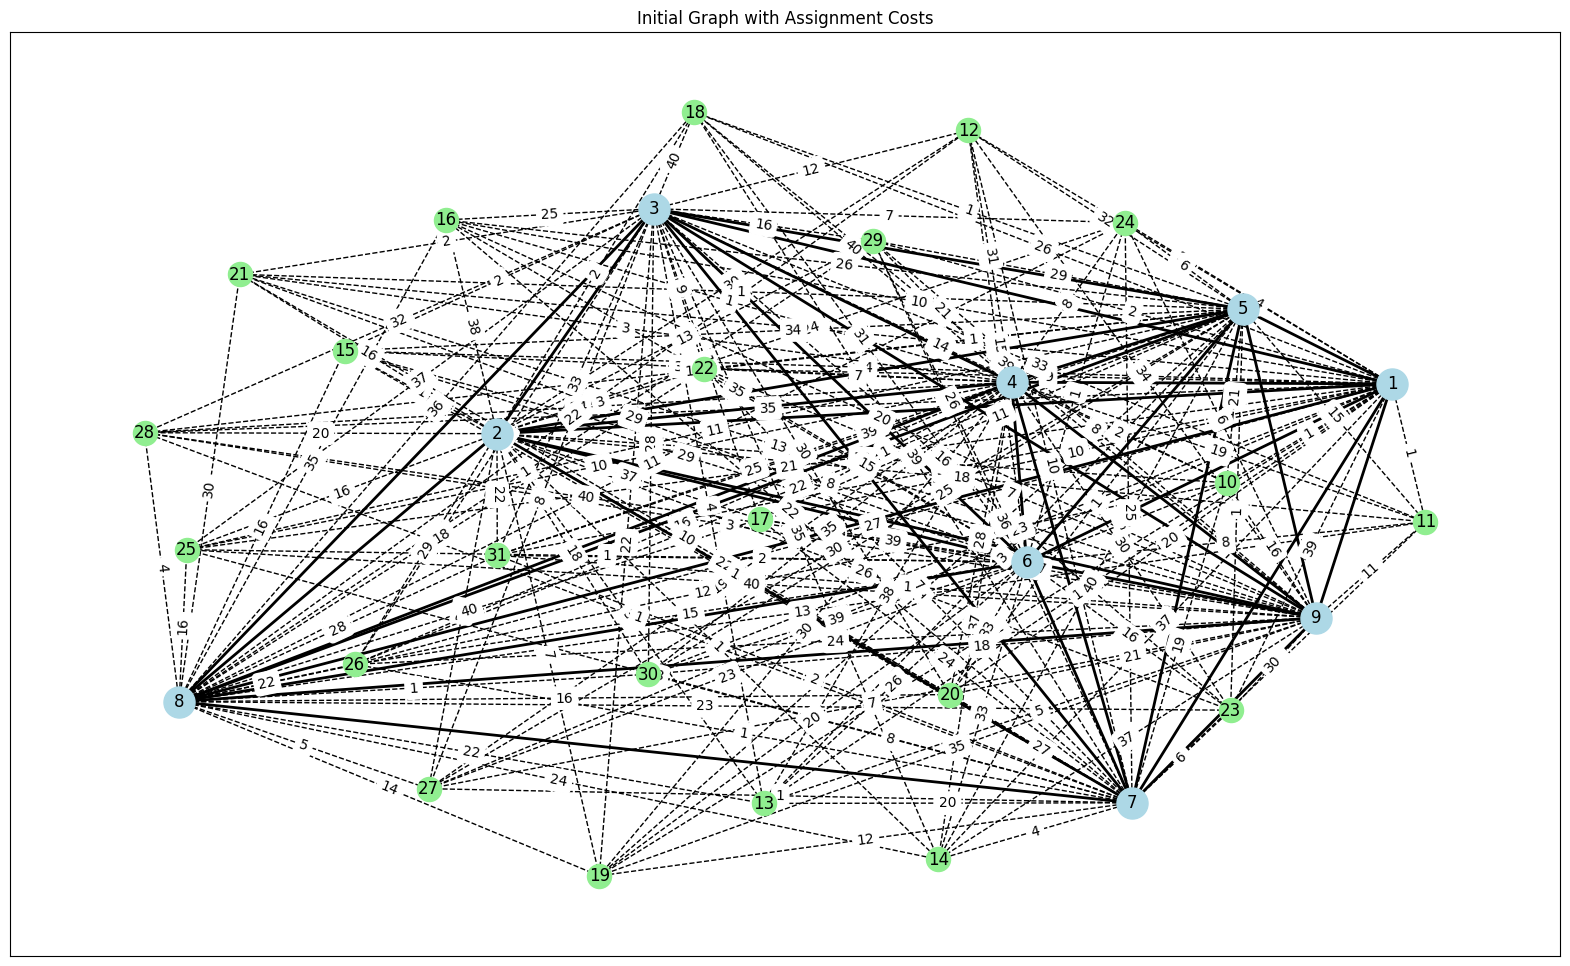

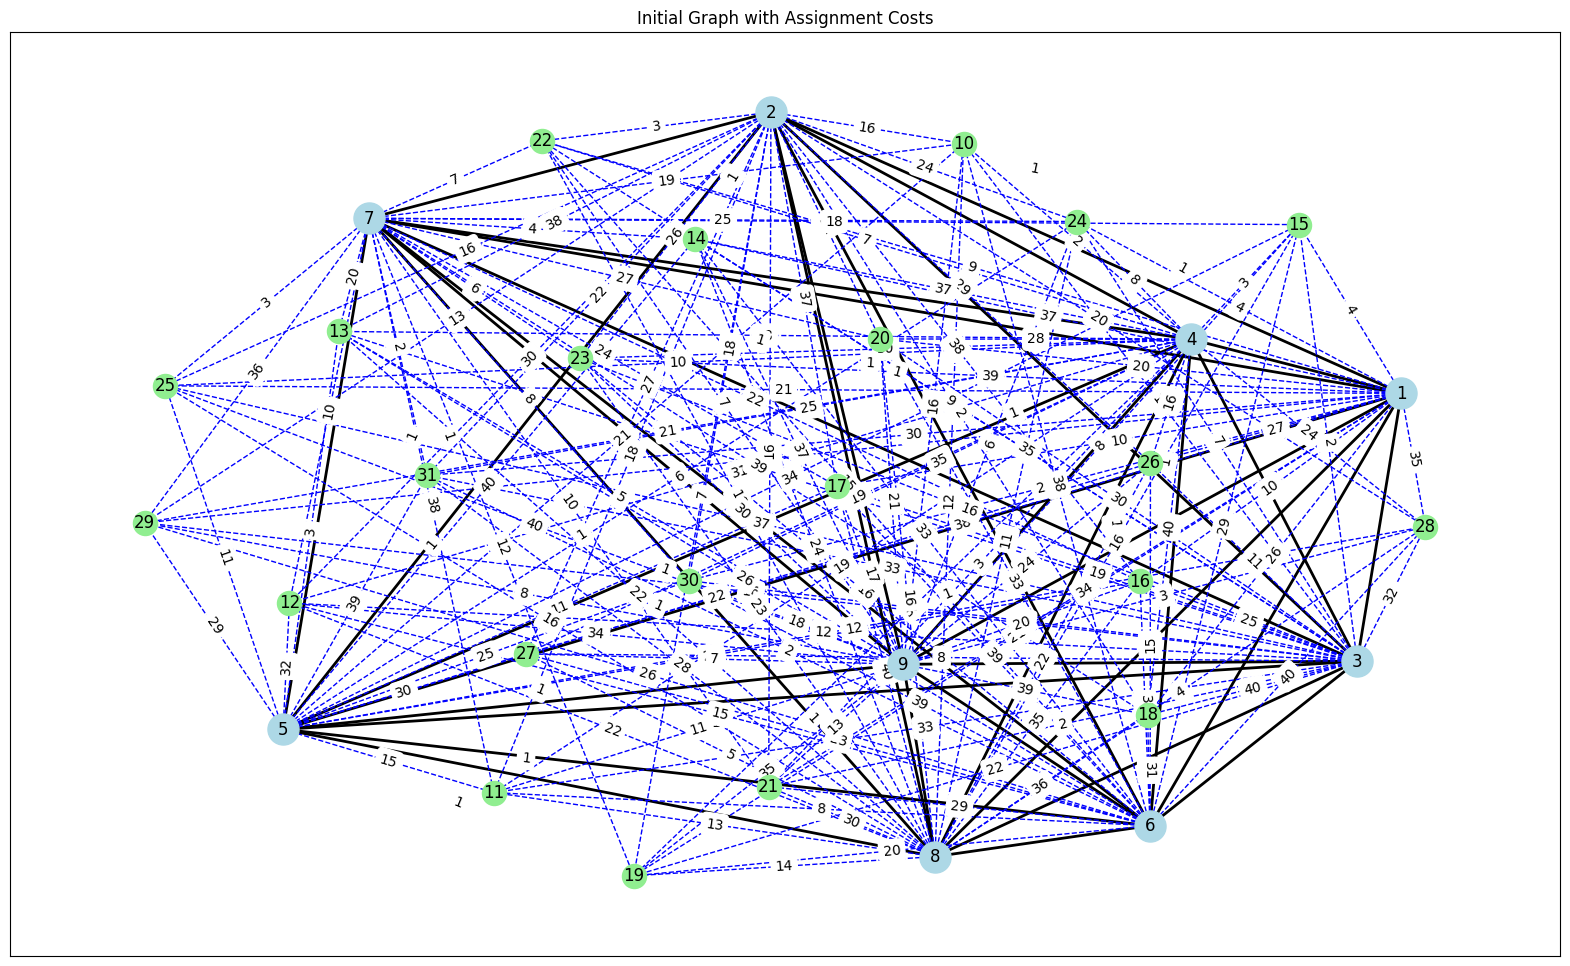

In [11]:
problem_instance = RingStarProblem(max_v=V, max_w=W, input_graph=G)
problem_instance.draw_initial_graph()
problem_instance.draw_initial_graph_minimum()
#problem_instance.solve_model()

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31 rows, 234 columns and 270 nonzeros
Model fingerprint: 0x8517784d
Variable types: 0 continuous, 234 integer (234 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 604.0000000
Presolve time: 0.00s
Presolved: 31 rows, 234 columns, 270 nonzeros
Variable types: 0 continuous, 234 integer (234 binary)
Found heuristic solution: objective 232.0000000

Root relaxation: objective 1.240000e+02, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0  

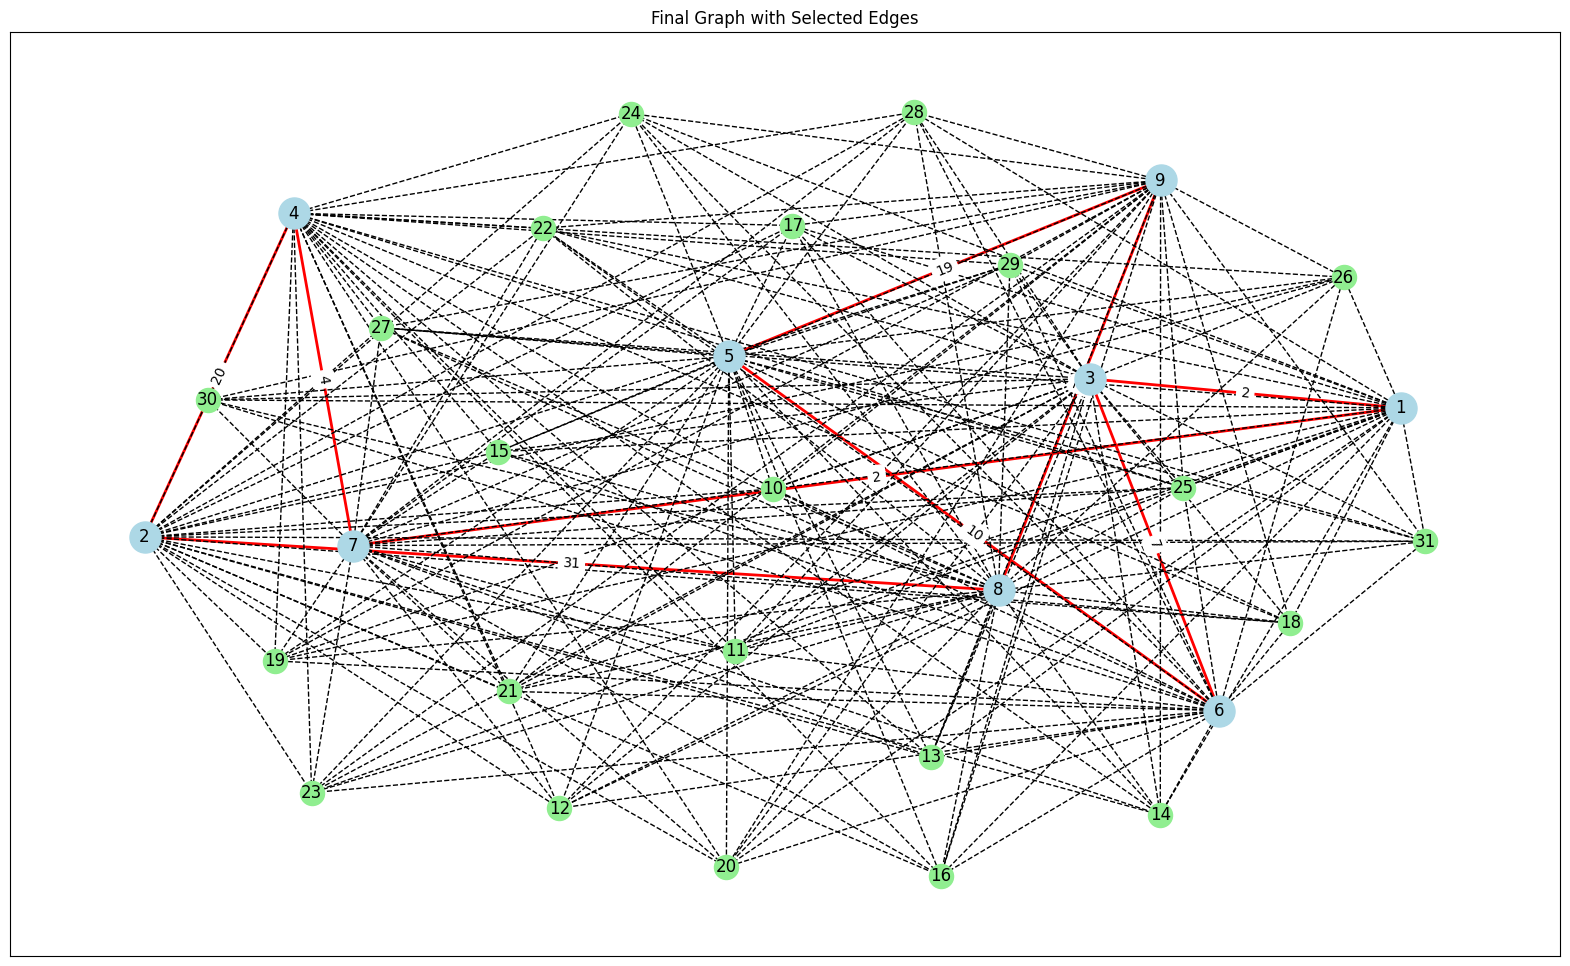

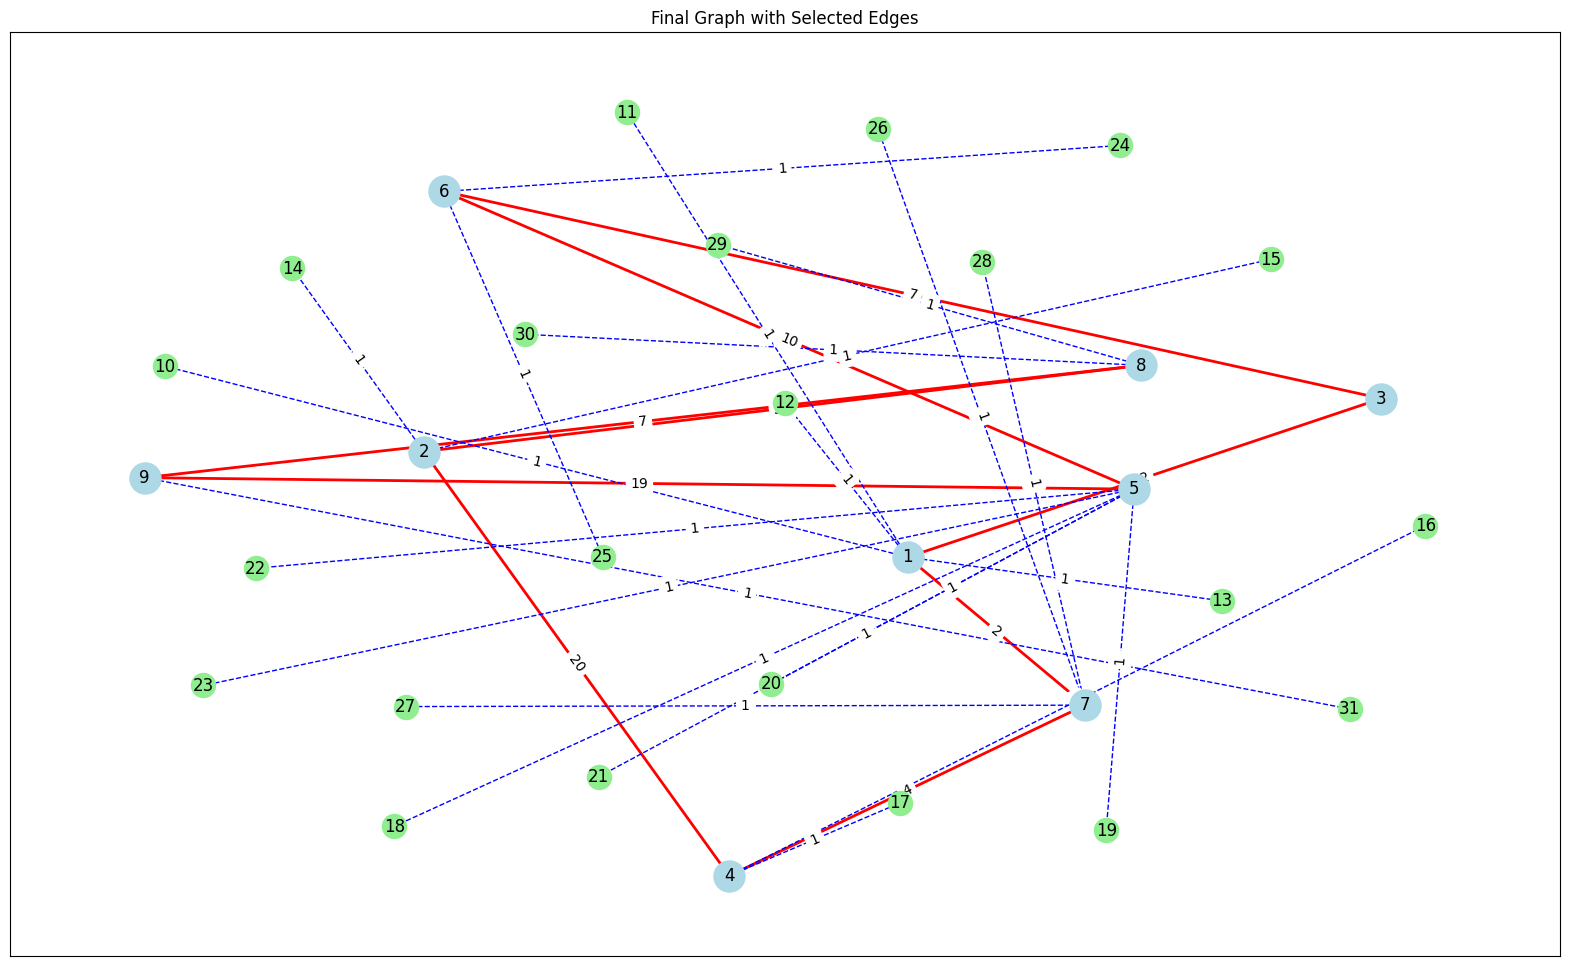

In [12]:
problem_instance.solve_model()

========== INITIAL INFO ==========
Cycle nodes (3) : [1, 2, 3]
Terminal nodes(10) : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


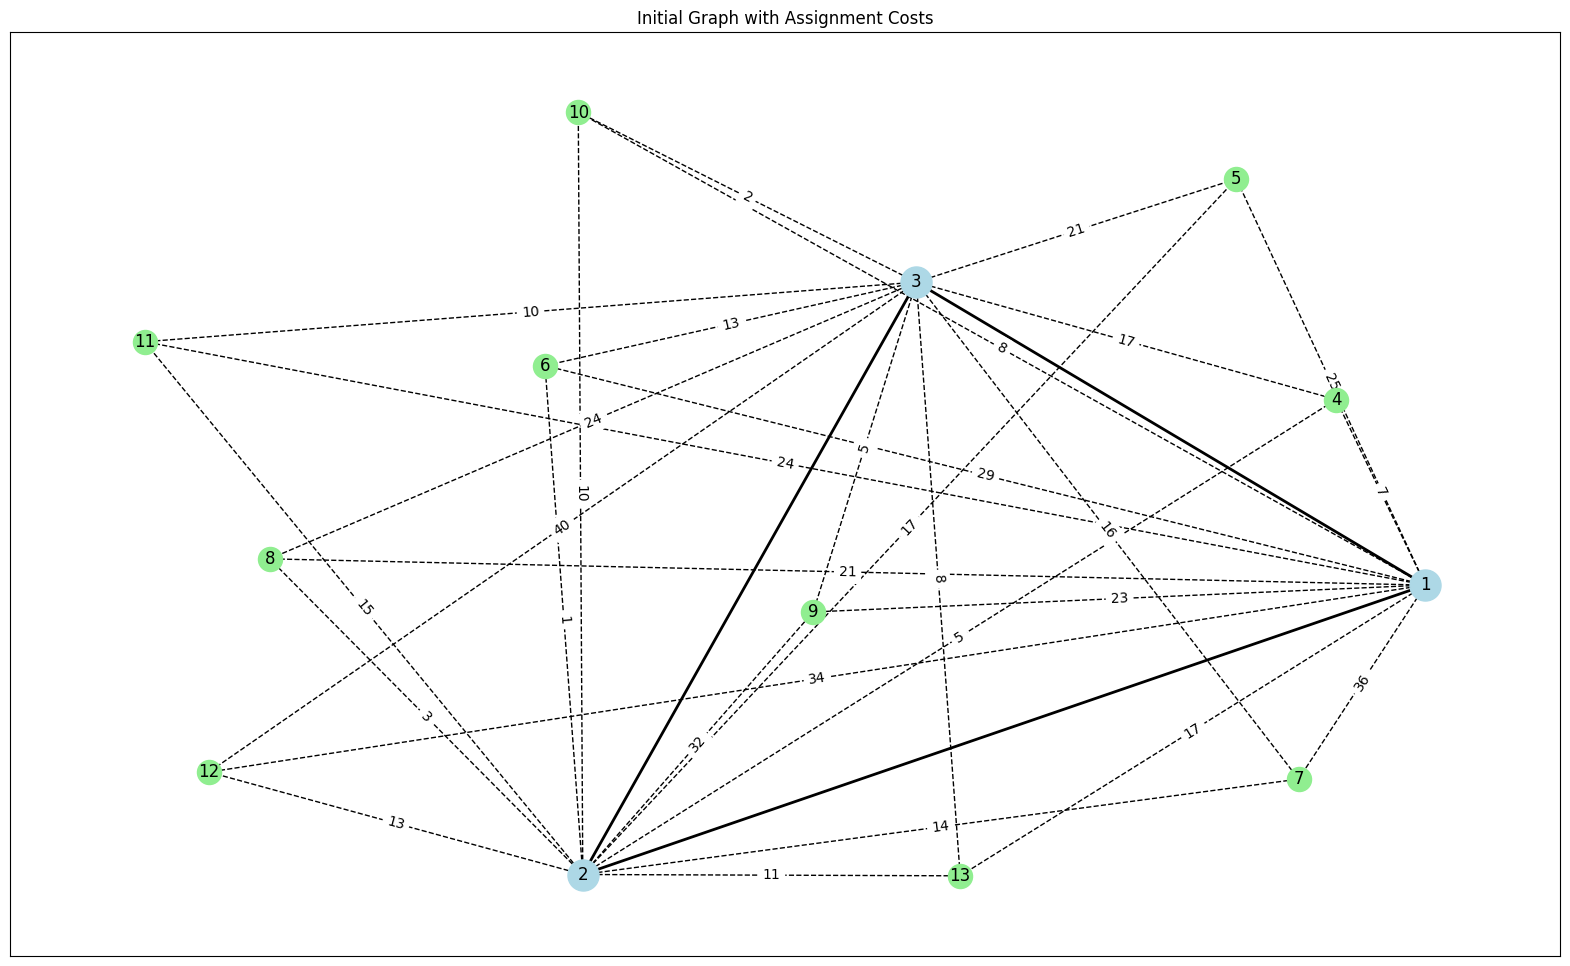

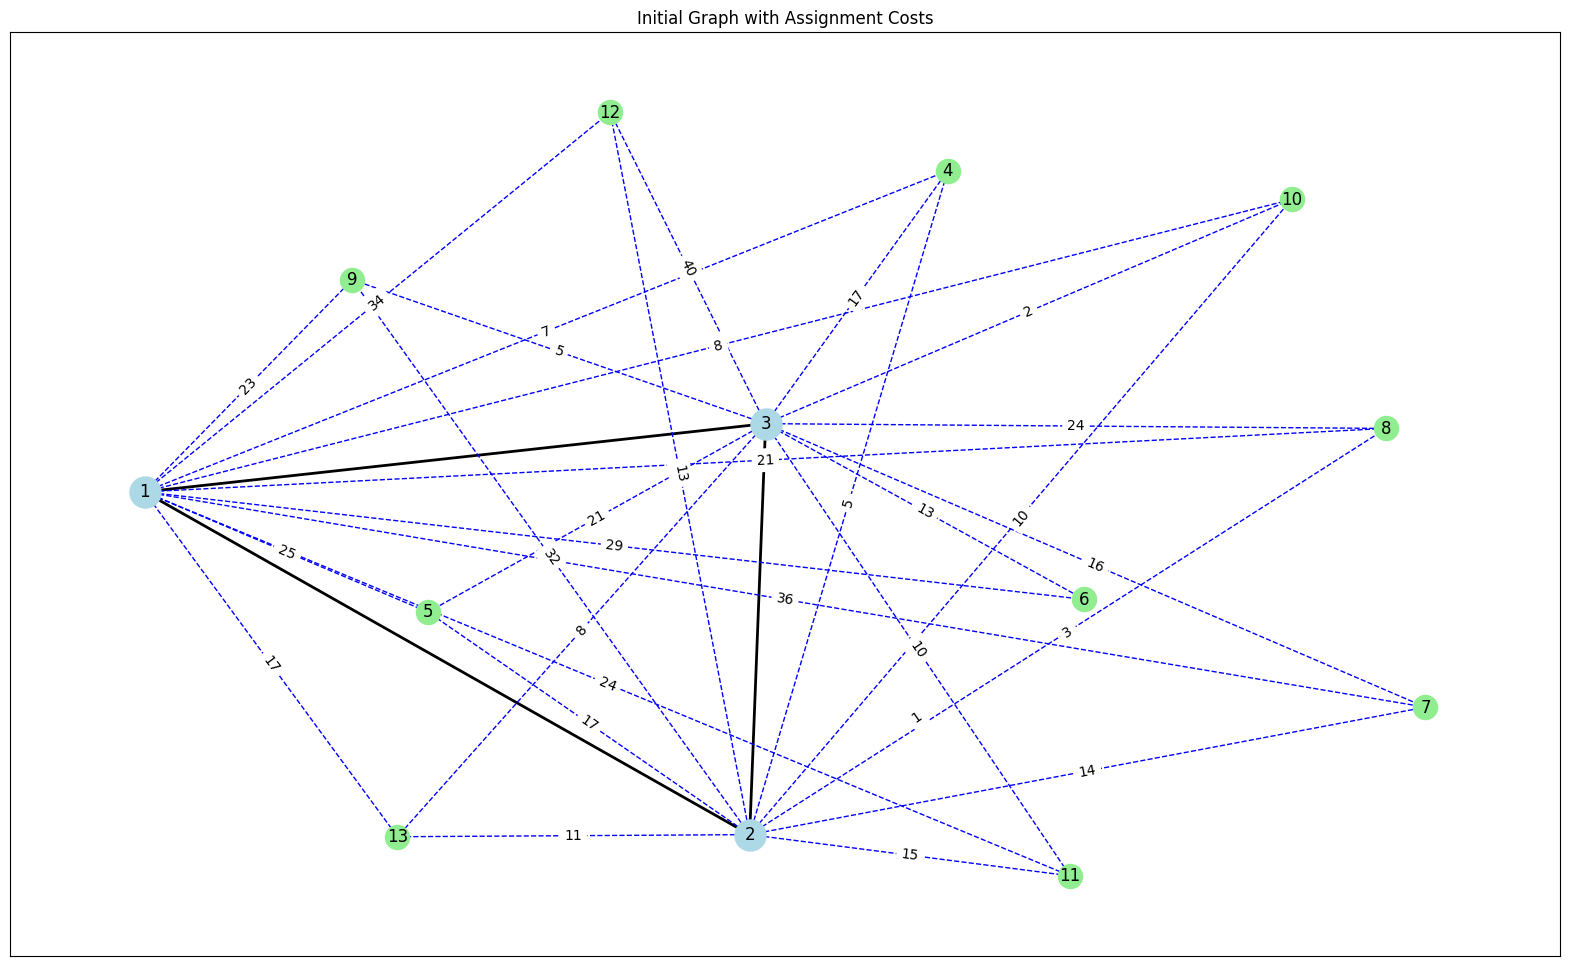

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 33 columns and 36 nonzeros
Model fingerprint: 0xd8110c13
Variable types: 0 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 263.0000000
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolved: 10 rows, 30 columns, 30 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)
Found heuristic solution: objective 117.0000000

Root relaxation: cutoff, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

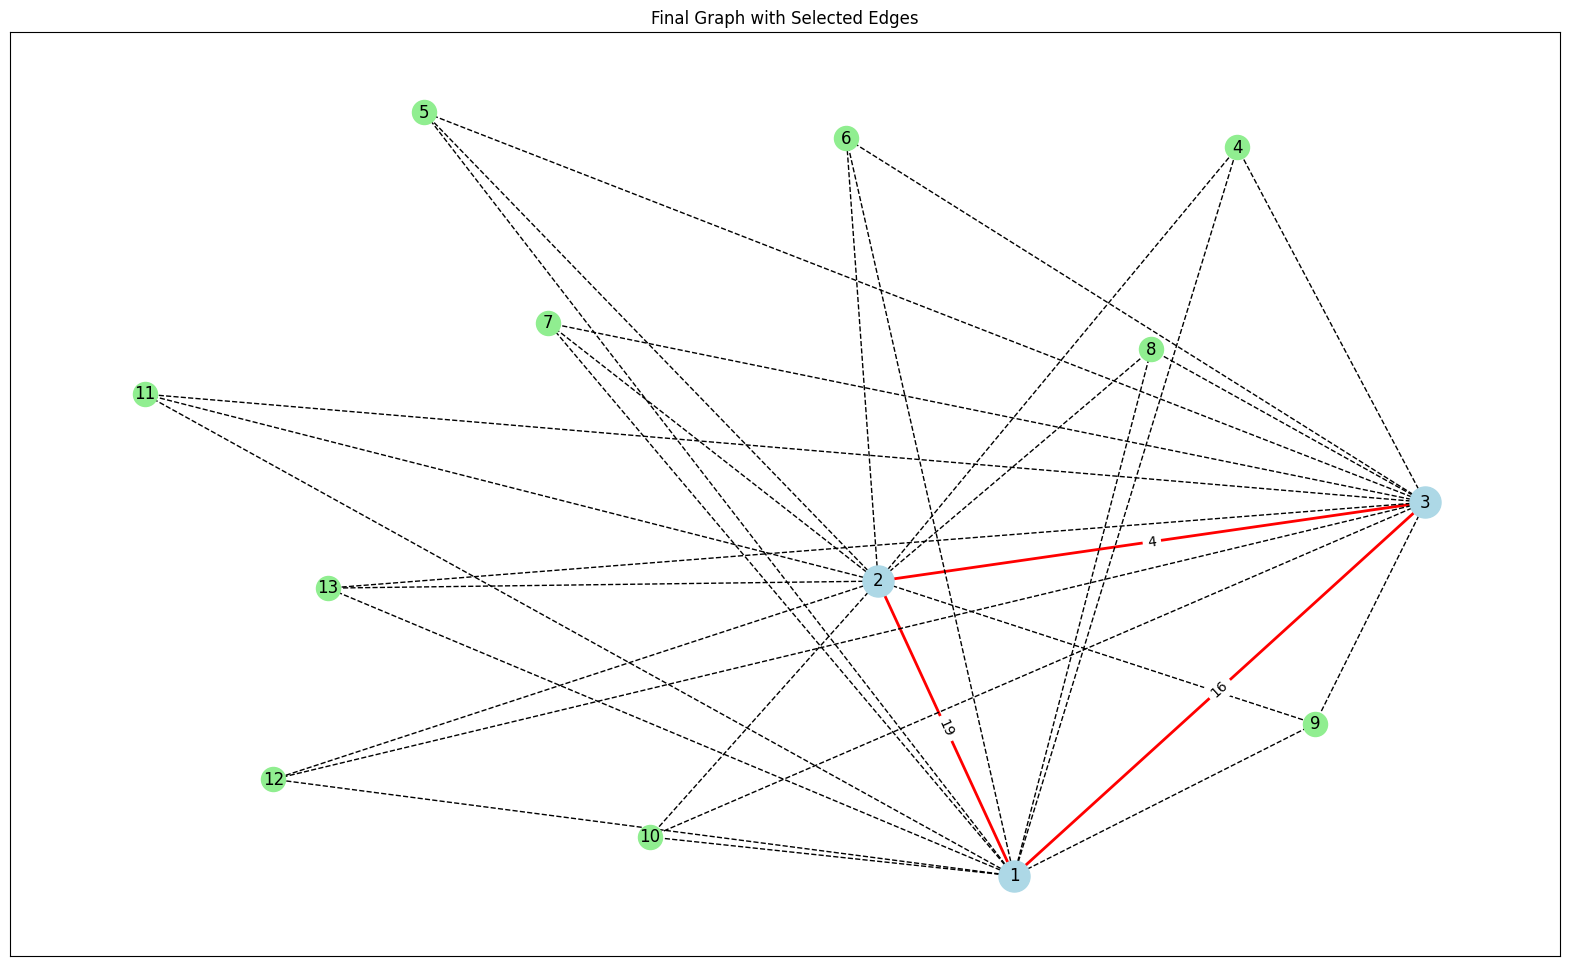

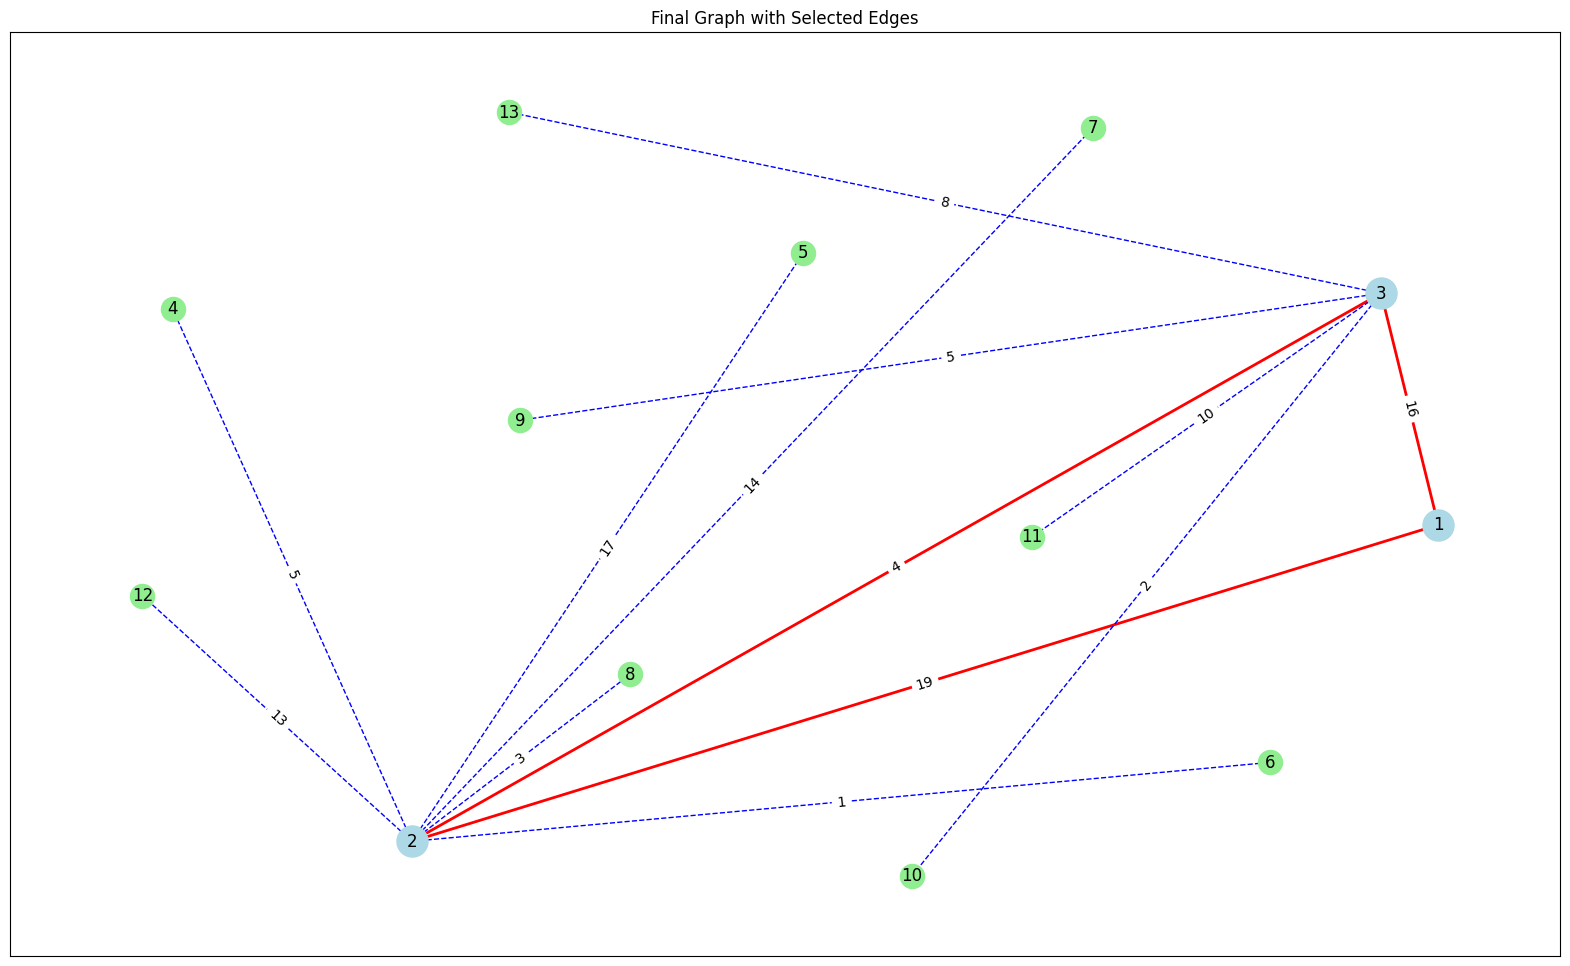

In [13]:
problem_instance = RingStarProblem(max_v=3, max_w=10)
problem_instance.draw_initial_graph()
problem_instance.draw_initial_graph_minimum()
problem_instance.solve_model()